<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/1_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [22]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)
root_path = 'drive/MyDrive/Colab Notebooks/data/'

Mounted at /content/drive


In [23]:
# !unzip "drive/MyDrive/Colab Notebooks/data//images_train.zip"
# !unzip "drive/MyDrive/Colab Notebooks/data//masks_train.zip"

In [24]:
path_images = root_path + 'images/'
path_masks = root_path + 'masks/'

In [25]:
from os.path import isfile, join
from os import listdir
def get_files(dir):
  onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
  return onlyfiles

In [26]:
import numpy as np
X = np.load('/content/images/' + get_files(path_images)[0])

for filename in get_files(path_images)[1:]:
    temp = np.load('/content/images/' + filename, allow_pickle=True)
    X = np.concatenate((X, temp))
del temp

In [27]:
color_channels = int(X.shape[0]/len(get_files(path_images)))
num_images = int(X.shape[0]/color_channels)
X = np.reshape(X, (num_images, color_channels, X.shape[1], X.shape[2]))
# X.shape: (20, 10, 1024, 1024)
del color_channels, num_images

In [28]:
y = np.load('/content/masks/' + get_files(path_masks)[0])

for filename in get_files(path_masks)[1:]:
    temp = np.load('/content/masks/' + filename, allow_pickle=True)
    y = np.concatenate((y, temp))
del temp

In [29]:
# remove drive connection as it is no longer needed
drive.flush_and_unmount()

In [30]:
# ceil the values at 2000 because clouds have a different reflection value
ceiling = 2000
X[X > ceiling] = ceiling
#scale values between 0 and 1
X = X/ceiling

Extract only parts of the image that are labeled.

In [31]:
# extract non-zero value indices from y (= label position) to extract the corresponding X-value
# this has to be done for every image, because X has a different length than y,
# if both are flattened due to more color channels
X_labeled = X[0].flat[np.nonzero(y[0].flat)[0]]
for img_idx in range(1, y.shape[0]):
  cur_img_nonzero_indices = np.nonzero(y[img_idx].flat)[0]
  corresponding_cur_X_values = X[img_idx].flat[cur_img_nonzero_indices]
  X_labeled = np.concatenate((X_labeled, corresponding_cur_X_values))

del corresponding_cur_X_values, cur_img_nonzero_indices

In [32]:
# y just has one dimension, so no loop is needed
y_labeled = y.flat[np.nonzero(y.flat)[0]]
# the length of X and y has to be the same
assert y_labeled.shape == X_labeled.shape

Train a first model to label the other pixels of the images.

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=0, shuffle=True)

In [125]:
del X_labeled, y_labeled

In [89]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [100, 200, 500] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': ['mse', 'mae'],
               'bootstrap': bootstrap}

In [35]:
X_train = X_train.reshape(-1, 1)

In [102]:
%%time
from sklearn.ensemble import RandomForestRegressor
# initialize model
rf = RandomForestRegressor(n_estimators=100, max_features='log2', max_depth=10, bootstrap=True)

# train model
rf.fit(X_train, y_train)

CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 2.76 s


RandomForestRegressor(max_depth=10, max_features='log2')

In [37]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# initialize model
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# train model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 8.76 s, sys: 906 ms, total: 9.67 s
Wall time: 35min 22s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, verbose=2)

In [38]:
rf_random.best_params_

{'n_estimators': 200,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [39]:
import joblib
# save model
joblib.dump(rf, 'random_forest.joblib')

['random_forest.joblib']

In [127]:
del X_train, y_train

In [109]:
rf = joblib.load("random_forest.joblib")

In [42]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [ ]:
X_test = X_test.reshape(-1, 1)

In [44]:
base_accuracy = evaluate(rf_random, X_test, y_test)

Model Performance
Average Error: 5.4299 degrees.
Accuracy = 19.78%.


In [58]:
y_pred = rf_random.predict(X_test)

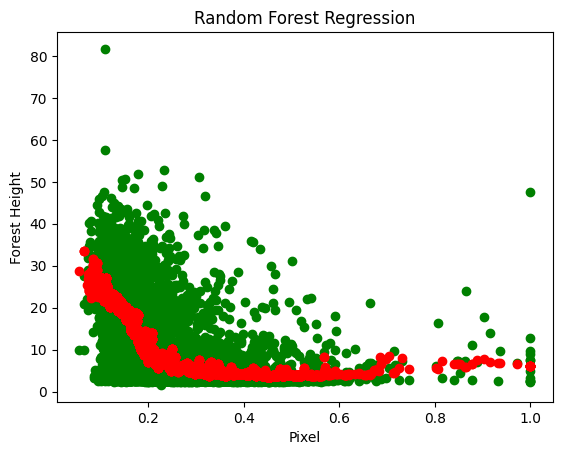

In [56]:
from matplotlib import pyplot as plt
plt.scatter(X_test, y_test, color = 'green')
plt.scatter(X_test, y_pred, color = 'red')
plt.title('Random Forest Regression')
plt.xlabel('Pixel')
plt.ylabel('Forest Height')
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))

MAE:  5.429856478366948
MSE:  61.25939618930059


In [111]:
def reshapeX(x):
  assert len(x.shape) == 4
  imgs, color_channels, hor, ver = X.shape
  x = np.reshape(x, (color_channels, imgs*hor*ver))
  print(x.shape)
  return x.reshape(-1, 1)

In [113]:
%%time
y_all_predicted = rf_random.predict(reshapeX(X))

(10, 20971520)
CPU times: user 16min 28s, sys: 2min, total: 18min 29s
Wall time: 18min 37s


In [118]:
y_all_predicted = y_all_predicted.reshape((imgs, color_channels, hor, ver))
np.save('X_predicted.npy', y_all_predicted)
# load with X_predicted = np.load('y_all_predicted.npy')y

In [128]:
del X_test, y_test

Check if the height predictions are acceptable and align with the rgb values by visual inspection.

In [ ]:
def normalize_color(img):
  assert len(img.shape) == 3
  # Extract Red, Green, and Blue bands
  red = img[2, :, :]
  green = img[1, :, :]
  blue = img[0, :, :]

  # Normalize the bands to [0, 1] range
  red_norm = (red - red.min()) / (red.max() - red.min())
  green_norm = (green - green.min()) / (green.max() - green.min())
  blue_norm = (blue - blue.min()) / (blue.max() - blue.min())

  return np.stack((red_norm, green_norm, blue_norm), axis=-1)

In [ ]:
import matplotlib.pyplot as plt
def plot(img):
    #satellite image
    if(len(img.shape) == 3):
      img = normalize_color(img)

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

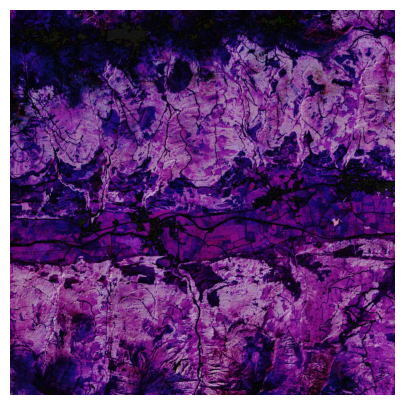

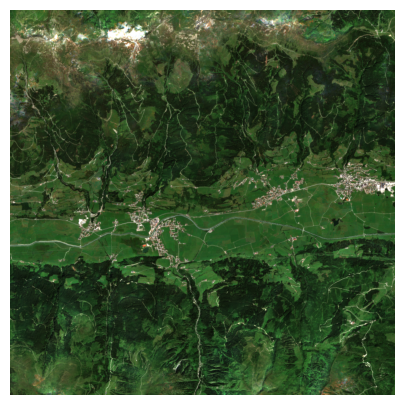

In [142]:
plot(y_all_predicted[0])
plot(X[0])

Alternative loading and storing of data:
```
# create data sets by combining npy files
path_train_sat = root_path + "train_satellite.npy"
path_train_masks = root_path + "train_masks.npy"

from os import listdir
if not isfile(path_train_sat):
  print("train satellite dataset is generated")
  # image set
  # initialize with the first satellite image
  train_satellite = np.load(path_images + listdir(path_images)[0])
  # concatinate all other images
  for f in listdir(path_images)[1:]:
      current_array = np.load(path_images + f, allow_pickle=True)
      train_satellite = np.concatenate((train_satellite, current_array), axis=0)
  # adjust incorrect shape: (200, 1024, 1024)
  train_satellite = train_satellite.reshape(20, 10, 1024, 1024)
  # save as file
  np.save(path_train_sat, train_satellite, allow_pickle=True, fix_imports=True)
if not isfile(path_train_masks):
  print("train masks dataset is generated")
  # masks
  # initialize with the first mask image
  train_masks = np.load(path_masks + listdir(path_masks)[0])
  # concatinate all other images
  for f in listdir(path_masks)[1:]:
      current_array = np.load(path_masks + f, allow_pickle=True)
      train_masks = np.concatenate((train_masks, current_array), axis=0)
  # save as file
  np.save(root_path + "train_masks.npy", train_masks, allow_pickle=True, fix_imports=True)
  ```

# Handling Large Images: Creating Cutouts
Split the large image into smaller sub-images. Use these for training and prediction.

In [ ]:
!pip install patchify

In [ ]:
from patchify import patchify, unpatchify

patch_shape = (10, 256, 256) # needs to have the same number of dimensions as the whole image
step_size = 256 # cuurently exact cropping of images with no overlap

# patchify has to be executed for each image individually
# initialize all patches with patches from first image. Then add all other patches
first_patches = patchify(X[0], patch_shape, step=step_size)
all_patches = first_patches
for idx in range(1, X.shape[0]):
  img = X[idx]
  patches = patchify(img, patch_shape, step=step_size)
  # add all other patches
  all_patches = np.concatenate((all_patches, patches))

In [ ]:
# check if patch shape is as planned
assert all_patches.shape == (20, 4, 4, 10, 256, 256)

check if the original image can be reconstructed:

In [ ]:
all_reconstructed_images = unpatchify(first_patches, X[0].shape)
for idx in range(1, X.shape[0]):
  #select single patch to unpatchify it
  patches = np.expand_dims(all_patches[idx], 0)
  reconstructed_image = unpatchify(patches, X[0].shape)
  all_reconstructed_images = np.concatenate((all_reconstructed_images, reconstructed_image))

all_reconstructed_images = np.reshape(all_reconstructed_images, X.shape)

In [ ]:
# check if unpatchify worked
assert (all_reconstructed_images == X).all()

In [ ]:
del all_reconstructed_images, reconstructed_image

In [ ]:
# put x and y axis patches together
all_patches = np.reshape(all_patches, (all_patches.shape[0], all_patches.shape[1]*all_patches.shape[2], all_patches.shape[3], all_patches.shape[4], all_patches.shape[5]))

In [ ]:
mask_patch_shape = (patch_shape[1], patch_shape[2]) # adjust to mask dimensions

# patchify has to be executed for each image individually
# initialize all patches with patches from first image. Then add all other patches
all_mask_patches = patchify(y[0], mask_patch_shape, step=step_size)
for idx in range(1, y.shape[0]):
  img = y[idx]
  patches = patchify(img, mask_patch_shape, step=step_size)
  # add all other patches
  all_mask_patches = np.concatenate((all_mask_patches, patches))
del patches

In [ ]:
all_mask_patches = np.reshape(all_mask_patches, (y.shape[0], all_mask_patches.shape[1]**2, all_mask_patches.shape[2], all_mask_patches.shape[3]))

# Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow import keras
#Data augmentation
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #keras.layers.experimental.preprocessing.RandomRotation(0.4),
    #keras.layers.RandomCrop(224, 224)
])

In [ ]:
image = normalize_color(all_patches[0][0][0][:3])

In [ ]:
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(hspace=0.07, wspace=0.01)
  plt.imshow(augmented_image)
  plt.axis("off")
  #print(augmented_image.shape)
  #print(i)
  #plot_img(augmented_image)

del augmented_image, image

# Dataset Generation

In [ ]:
#conversion to tensors
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((all_patches, all_mask_patches))

In [ ]:
dataset.element_spec